In [1]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
import random, gc, keras, os

from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, AveragePooling2D
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau

from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.resnet50 import ResNet50
from keras.applications.inception_v3 import InceptionV3
from keras.applications.xception import Xception
from keras.applications.densenet import DenseNet121

%matplotlib inline

Using TensorFlow backend.


# Load Dataset

In [2]:
train_df = pd.read_csv('./data/train.csv')
val_df = pd.read_csv('./data/validation.csv')
test_df = pd.read_csv('./data/test.csv')

print('Train:\t\t', train_df.shape, '\t', len(train_df['label'].unique()))
print('Validation:\t', val_df.shape, '\t', len(val_df['label'].unique()))
print('Test:\t\t', test_df.shape)

Train:		 (194828, 3) 	 128
Validation:	 (6400, 3) 	 128
Test:		 (12800, 2)


In [3]:
train_df.head()

,id,label,url
0,1,5,https://img13.360buyimg.com/imgzone/jfs/t2857/...
1,2,5,http://www.tengdakeli.cn/350/timg01/uploaded/i...
2,3,5,https://img13.360buyimg.com/imgzone/jfs/t8899/...
3,4,5,http://img4.tbcdn.cn/tfscom/i1/2855447419/TB2S...
4,5,5,http://a.vpimg4.com/upload/merchandise/287883/...


In [4]:
# Helper function
train_dir = './data/train'
val_dir = './data/validation'
test_dir = './data/test'

def lr_schedule(epoch):
    """ Learning rate schedule """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

# 1. VGG16

In [5]:
# For reproduciable purpose
seed = 42
K.clear_session()
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(seed)
random.seed(seed)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
tf.set_random_seed(seed)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

# Define parameters
classes = [str(i) for i in range(1, 129)]

# define image generator
train_gen = ImageDataGenerator(rescale=1.0/255)
train_generator = train_gen.flow_from_directory(train_dir, batch_size=160, classes=classes, 
                                                target_size=(224, 224))

val_gen = ImageDataGenerator(rescale=1.0/255)
val_generator = val_gen.flow_from_directory(val_dir, batch_size=286, classes=classes, 
                                            target_size=(224, 224))

Found 191680 images belonging to 128 classes.
Found 6292 images belonging to 128 classes.


### Initial training

In [6]:
# Load pre-trained VGG16
vgg16_base = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Define new CNN models
vgg16 = Sequential()
vgg16.add(vgg16_base)
vgg16.add(Flatten(name='flatten'))
vgg16.add(Dense(128, activation='softmax', name='prediction'))

# Make base model untrainable
vgg16_base.trainable = False

# Model summary
vgg16.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
prediction (Dense)           (None, 128)               3211392   
Total params: 17,926,080
Trainable params: 3,211,392
Non-trainable params: 14,714,688
_________________________________________________________________


In [7]:
# Compile the model
opt = keras.optimizers.Adam(lr=lr_schedule(0))
vgg16.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Create call backs
checkpoint = ModelCheckpoint(filepath='./models/vgg16_1_initial.h5', verbose=0, 
                             monitor='val_acc', save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=5, min_lr=0.5e-6)
callbacks = [checkpoint, lr_reducer, lr_scheduler]

# fit the mode
history = vgg16.fit_generator(train_generator, steps_per_epoch=100, epochs=10, verbose=2, 
                              callbacks=callbacks, validation_data=val_generator, validation_steps=22)
_ = gc.collect()

Learning rate:  0.001
Epoch 1/10
Learning rate:  0.001
 - 253s - loss: 2.6649 - acc: 0.4079 - val_loss: 2.3919 - val_acc: 0.4973
Epoch 2/10
Learning rate:  0.001
 - 224s - loss: 1.8587 - acc: 0.5640 - val_loss: 2.1396 - val_acc: 0.5504
Epoch 3/10
Learning rate:  0.001
 - 221s - loss: 1.6851 - acc: 0.5981 - val_loss: 2.2093 - val_acc: 0.5655
Epoch 4/10
Learning rate:  0.001
 - 221s - loss: 1.6785 - acc: 0.6124 - val_loss: 2.0673 - val_acc: 0.5796
Epoch 5/10
Learning rate:  0.001
 - 220s - loss: 1.6629 - acc: 0.6256 - val_loss: 2.1212 - val_acc: 0.5884
Epoch 6/10
Learning rate:  0.001
 - 224s - loss: 1.5998 - acc: 0.6389 - val_loss: 2.1418 - val_acc: 0.5901
Epoch 7/10
Learning rate:  0.001
 - 223s - loss: 1.5896 - acc: 0.6429 - val_loss: 1.9979 - val_acc: 0.6090
Epoch 8/10
Learning rate:  0.001
 - 223s - loss: 1.6039 - acc: 0.6526 - val_loss: 1.9787 - val_acc: 0.6157
Epoch 9/10
Learning rate:  0.001
 - 223s - loss: 1.5724 - acc: 0.6549 - val_loss: 1.9988 - val_acc: 0.6254
Epoch 10/10
Lea

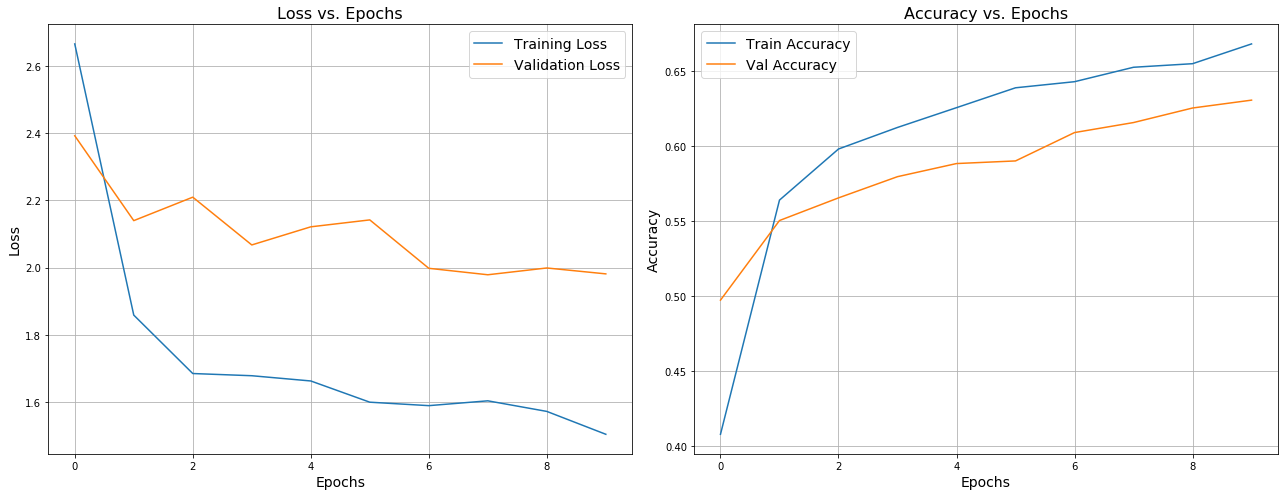

In [8]:
# Visualize the training process
train_loss = history.history['loss']
train_acc = history.history['acc']
val_loss = history.history['val_loss']
val_acc = history.history['val_acc']

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 7))
ax[0].plot(train_loss, label='Training Loss')
ax[0].plot(val_loss, label='Validation Loss')
ax[0].set_title('Loss vs. Epochs', fontsize=16)
ax[0].set_xlabel('Epochs', fontsize=14)
ax[0].set_ylabel('Loss', fontsize=14)
ax[0].legend(fontsize=14)
ax[0].grid(True)

ax[1].plot(train_acc, label='Train Accuracy')
ax[1].plot(val_acc, label='Val Accuracy')
ax[1].set_title('Accuracy vs. Epochs', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=14)
ax[1].set_ylabel('Accuracy', fontsize=14)
ax[1].legend(fontsize=14)
ax[1].grid(True)
plt.tight_layout()
plt.show()

# 2. VGG19

In [9]:
# For reproduciable purpose
seed = 42
K.clear_session()
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(seed)
random.seed(seed)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
tf.set_random_seed(seed)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

# Define parameters
classes = [str(i) for i in range(1, 129)]

# define image generator
train_gen = ImageDataGenerator(rescale=1.0/255)
train_generator = train_gen.flow_from_directory(train_dir, batch_size=160, classes=classes, 
                                                target_size=(224, 224))

val_gen = ImageDataGenerator(rescale=1.0/255)
val_generator = val_gen.flow_from_directory(val_dir, batch_size=286, classes=classes, 
                                            target_size=(224, 224))

Found 191680 images belonging to 128 classes.
Found 6292 images belonging to 128 classes.


### Initial training

In [10]:
# Load pre-trained VGG19
vgg19_base = VGG19(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Define new CNN models
vgg19 = Sequential()
vgg19.add(vgg19_base)
vgg19.add(Flatten(name='flatten'))
vgg19.add(Dense(128, activation='softmax', name='prediction'))

# Make base model untrainable
vgg19_base.trainable = False

# Model summary
vgg19.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
prediction (Dense)           (None, 128)               3211392   
Total params: 23,235,776
Trainable params: 3,211,392
Non-trainable params: 20,024,384
_________________________________________________________________


In [11]:
# Compile the model
opt = keras.optimizers.Adam(lr=lr_schedule(0))
vgg19.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Create call backs
checkpoint = ModelCheckpoint(filepath='./models/vgg19_1_initial.h5', verbose=0, 
                             monitor='val_acc', save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=5, min_lr=0.5e-6)
callbacks = [checkpoint, lr_reducer, lr_scheduler]

# fit the mode
history = vgg19.fit_generator(train_generator, steps_per_epoch=100, epochs=10, verbose=2, 
                              callbacks=callbacks, validation_data=val_generator, validation_steps=22)
_ = gc.collect()

Learning rate:  0.001
Epoch 1/10
Learning rate:  0.001
 - 220s - loss: 2.8760 - acc: 0.3853 - val_loss: 2.6273 - val_acc: 0.4663
Epoch 2/10
Learning rate:  0.001
 - 203s - loss: 2.0071 - acc: 0.5363 - val_loss: 2.5281 - val_acc: 0.5118
Epoch 3/10
Learning rate:  0.001
 - 199s - loss: 1.9333 - acc: 0.5585 - val_loss: 2.5285 - val_acc: 0.5291
Epoch 4/10
Learning rate:  0.001
 - 199s - loss: 1.8477 - acc: 0.5836 - val_loss: 2.3366 - val_acc: 0.5435
Epoch 5/10
Learning rate:  0.001
 - 198s - loss: 1.8548 - acc: 0.5961 - val_loss: 2.3399 - val_acc: 0.5601
Epoch 6/10
Learning rate:  0.001
 - 206s - loss: 1.8018 - acc: 0.6064 - val_loss: 2.3630 - val_acc: 0.5658
Epoch 7/10
Learning rate:  0.001
 - 199s - loss: 1.7414 - acc: 0.6201 - val_loss: 2.3303 - val_acc: 0.5791
Epoch 8/10
Learning rate:  0.001
 - 197s - loss: 1.7820 - acc: 0.6251 - val_loss: 2.2825 - val_acc: 0.5874
Epoch 9/10
Learning rate:  0.001
 - 200s - loss: 1.7520 - acc: 0.6314 - val_loss: 2.2557 - val_acc: 0.5995
Epoch 10/10
Lea

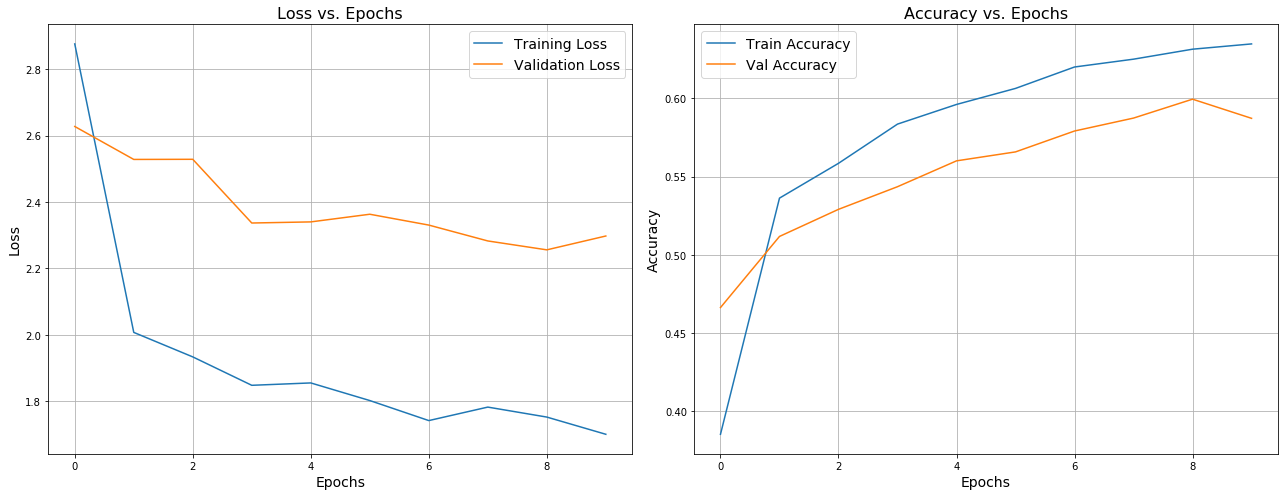

In [12]:
# Visualize the training process
train_loss = history.history['loss']
train_acc = history.history['acc']
val_loss = history.history['val_loss']
val_acc = history.history['val_acc']

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 7))
ax[0].plot(train_loss, label='Training Loss')
ax[0].plot(val_loss, label='Validation Loss')
ax[0].set_title('Loss vs. Epochs', fontsize=16)
ax[0].set_xlabel('Epochs', fontsize=14)
ax[0].set_ylabel('Loss', fontsize=14)
ax[0].legend(fontsize=14)
ax[0].grid(True)

ax[1].plot(train_acc, label='Train Accuracy')
ax[1].plot(val_acc, label='Val Accuracy')
ax[1].set_title('Accuracy vs. Epochs', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=14)
ax[1].set_ylabel('Accuracy', fontsize=14)
ax[1].legend(fontsize=14)
ax[1].grid(True)
plt.tight_layout()
plt.show()

# 3. ResNet50

In [13]:
# For reproduciable purpose
seed = 42
K.clear_session()
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(seed)
random.seed(seed)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
tf.set_random_seed(seed)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

# Define parameters
classes = [str(i) for i in range(1, 129)]

# define image generator
train_gen = ImageDataGenerator(rescale=1.0/255)
train_generator = train_gen.flow_from_directory(train_dir, batch_size=160, classes=classes, 
                                                target_size=(224, 224))

val_gen = ImageDataGenerator(rescale=1.0/255)
val_generator = val_gen.flow_from_directory(val_dir, batch_size=286, classes=classes, 
                                            target_size=(224, 224))

Found 191680 images belonging to 128 classes.
Found 6292 images belonging to 128 classes.


### Initial training

In [14]:
# Load pre-trained resnet (output shape=(None, 2048))
resnet_base = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Define new CNN models
resnet = Sequential()
resnet.add(resnet_base)
resnet.add(Flatten(name='flatten'))
resnet.add(Dense(128, activation='softmax', name='prediction'))

# Make base model untrainable
resnet_base.trainable = False

# Model summary
resnet.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 1, 1, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
prediction (Dense)           (None, 128)               262272    
Total params: 23,849,984
Trainable params: 262,272
Non-trainable params: 23,587,712
_________________________________________________________________


In [15]:
# Compile the model
opt = keras.optimizers.Adam(lr=lr_schedule(0))
resnet.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Create call backs
checkpoint = ModelCheckpoint(filepath='./models/resnet_1_initial.h5', verbose=0, 
                             monitor='val_acc', save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=5, min_lr=0.5e-6)
callbacks = [checkpoint, lr_reducer, lr_scheduler]

# fit the mode
history = resnet.fit_generator(train_generator, steps_per_epoch=100, epochs=10, verbose=2, 
                               callbacks=callbacks, validation_data=val_generator, validation_steps=22)
_ = gc.collect()

Learning rate:  0.001
Epoch 1/10
Learning rate:  0.001
 - 219s - loss: 2.7125 - acc: 0.3723 - val_loss: 5.5800 - val_acc: 0.0079
Epoch 2/10
Learning rate:  0.001
 - 199s - loss: 1.6091 - acc: 0.5762 - val_loss: 5.7520 - val_acc: 0.0079
Epoch 3/10
Learning rate:  0.001
 - 197s - loss: 1.3997 - acc: 0.6256 - val_loss: 5.8379 - val_acc: 0.0084
Epoch 4/10
Learning rate:  0.001
 - 196s - loss: 1.2892 - acc: 0.6487 - val_loss: 5.9053 - val_acc: 0.0079
Epoch 5/10
Learning rate:  0.001
 - 195s - loss: 1.2292 - acc: 0.6649 - val_loss: 6.0518 - val_acc: 0.0078
Epoch 6/10
Learning rate:  0.001
 - 195s - loss: 1.1934 - acc: 0.6727 - val_loss: 6.1568 - val_acc: 0.0078
Epoch 7/10
Learning rate:  0.001
 - 197s - loss: 1.1622 - acc: 0.6797 - val_loss: 6.1810 - val_acc: 0.0078
Epoch 8/10
Learning rate:  0.001
 - 197s - loss: 1.1306 - acc: 0.6858 - val_loss: 6.1765 - val_acc: 0.0078
Epoch 9/10
Learning rate:  0.001
 - 197s - loss: 1.0910 - acc: 0.6991 - val_loss: 6.2688 - val_acc: 0.0073
Epoch 10/10
Lea

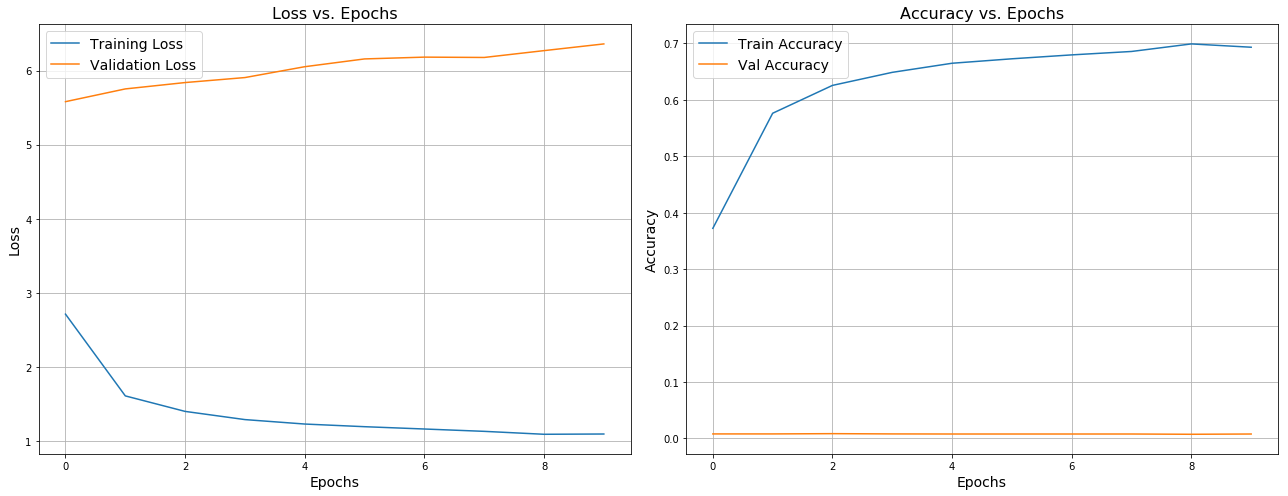

In [16]:
# Visualize the training process
train_loss = history.history['loss']
train_acc = history.history['acc']
val_loss = history.history['val_loss']
val_acc = history.history['val_acc']

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 7))
ax[0].plot(train_loss, label='Training Loss')
ax[0].plot(val_loss, label='Validation Loss')
ax[0].set_title('Loss vs. Epochs', fontsize=16)
ax[0].set_xlabel('Epochs', fontsize=14)
ax[0].set_ylabel('Loss', fontsize=14)
ax[0].legend(fontsize=14)
ax[0].grid(True)

ax[1].plot(train_acc, label='Train Accuracy')
ax[1].plot(val_acc, label='Val Accuracy')
ax[1].set_title('Accuracy vs. Epochs', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=14)
ax[1].set_ylabel('Accuracy', fontsize=14)
ax[1].legend(fontsize=14)
ax[1].grid(True)
plt.tight_layout()
plt.show()

# 4. InceptionV3

In [17]:
# For reproduciable purpose
seed = 42
K.clear_session()
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(seed)
random.seed(seed)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
tf.set_random_seed(seed)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

# Define parameters
classes = [str(i) for i in range(1, 129)]

# define image generator
train_gen = ImageDataGenerator(rescale=1.0/255)
train_generator = train_gen.flow_from_directory(train_dir, batch_size=160, classes=classes, 
                                                target_size=(224, 224))

val_gen = ImageDataGenerator(rescale=1.0/255)
val_generator = val_gen.flow_from_directory(val_dir, batch_size=286, classes=classes, 
                                            target_size=(224, 224))

Found 191680 images belonging to 128 classes.
Found 6292 images belonging to 128 classes.


### Initial training

In [18]:
# Load pre-trained InceptionV3
inception_base = InceptionV3(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Define new CNN models
inception = Sequential()
inception.add(inception_base)
inception.add(Flatten(name='flatten'))
inception.add(Dense(128, activation='softmax', name='prediction'))

# Make base model untrainable
inception_base.trainable = False

# Model summary
inception.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 5, 5, 2048)        21802784  
_________________________________________________________________
flatten (Flatten)            (None, 51200)             0         
_________________________________________________________________
prediction (Dense)           (None, 128)               6553728   
Total params: 28,356,512
Trainable params: 6,553,728
Non-trainable params: 21,802,784
_________________________________________________________________


In [19]:
# Compile the model
opt = keras.optimizers.Adam(lr=lr_schedule(0))
inception.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Create call backs
checkpoint = ModelCheckpoint(filepath='./models/inception_1_initial.h5', verbose=0, 
                             monitor='val_acc', save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=5, min_lr=0.5e-6)
callbacks = [checkpoint, lr_reducer, lr_scheduler]

# fit the mode
history = inception.fit_generator(train_generator, steps_per_epoch=100, epochs=10, verbose=2, 
                                  callbacks=callbacks, validation_data=val_generator, validation_steps=22)
_ = gc.collect()

Learning rate:  0.001
Epoch 1/10
Learning rate:  0.001
 - 222s - loss: 11.8836 - acc: 0.1759 - val_loss: 12.6664 - val_acc: 0.1758
Epoch 2/10
Learning rate:  0.001
 - 200s - loss: 11.4519 - acc: 0.2261 - val_loss: 12.6915 - val_acc: 0.1818
Epoch 3/10
Learning rate:  0.001
 - 198s - loss: 11.4940 - acc: 0.2334 - val_loss: 12.5766 - val_acc: 0.1931
Epoch 4/10
Learning rate:  0.001
 - 198s - loss: 11.4667 - acc: 0.2417 - val_loss: 12.8304 - val_acc: 0.1771
Epoch 5/10
Learning rate:  0.001
 - 196s - loss: 11.2662 - acc: 0.2559 - val_loss: 12.5863 - val_acc: 0.1960
Epoch 6/10
Learning rate:  0.001
 - 195s - loss: 11.2850 - acc: 0.2609 - val_loss: 12.6435 - val_acc: 0.1950
Epoch 7/10
Learning rate:  0.001
 - 199s - loss: 11.2911 - acc: 0.2631 - val_loss: 12.4503 - val_acc: 0.2063
Epoch 8/10
Learning rate:  0.001
 - 195s - loss: 11.2555 - acc: 0.2666 - val_loss: 12.4348 - val_acc: 0.2098
Epoch 9/10
Learning rate:  0.001
 - 198s - loss: 11.3096 - acc: 0.2645 - val_loss: 12.4850 - val_acc: 0.20

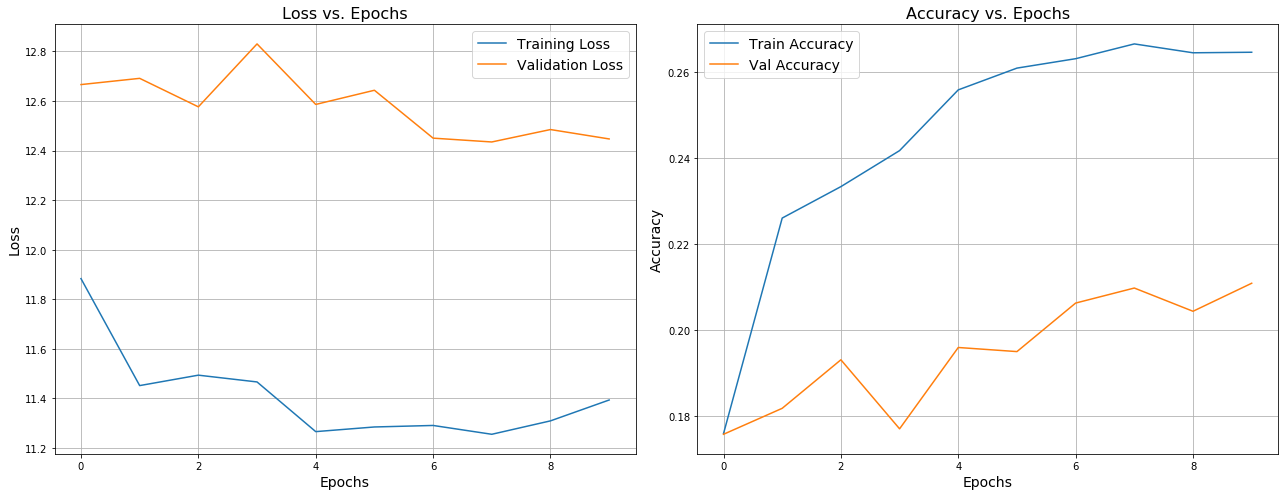

In [20]:
# Visualize the training process
train_loss = history.history['loss']
train_acc = history.history['acc']
val_loss = history.history['val_loss']
val_acc = history.history['val_acc']

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 7))
ax[0].plot(train_loss, label='Training Loss')
ax[0].plot(val_loss, label='Validation Loss')
ax[0].set_title('Loss vs. Epochs', fontsize=16)
ax[0].set_xlabel('Epochs', fontsize=14)
ax[0].set_ylabel('Loss', fontsize=14)
ax[0].legend(fontsize=14)
ax[0].grid(True)

ax[1].plot(train_acc, label='Train Accuracy')
ax[1].plot(val_acc, label='Val Accuracy')
ax[1].set_title('Accuracy vs. Epochs', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=14)
ax[1].set_ylabel('Accuracy', fontsize=14)
ax[1].legend(fontsize=14)
ax[1].grid(True)
plt.tight_layout()
plt.show()

# 5. Xception

In [21]:
# For reproduciable purpose
seed = 42
K.clear_session()
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(seed)
random.seed(seed)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
tf.set_random_seed(seed)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

# Define parameters
classes = [str(i) for i in range(1, 129)]

# define image generator
train_gen = ImageDataGenerator(rescale=1.0/255)
train_generator = train_gen.flow_from_directory(train_dir, batch_size=160, classes=classes, 
                                                target_size=(224, 224))

val_gen = ImageDataGenerator(rescale=1.0/255)
val_generator = val_gen.flow_from_directory(val_dir, batch_size=286, classes=classes, 
                                            target_size=(224, 224))

Found 191680 images belonging to 128 classes.
Found 6292 images belonging to 128 classes.


### Initial training

In [22]:
# Load pre-trained Xception
xception_base = Xception(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Define new CNN models
xception = Sequential()
xception.add(xception_base)
xception.add(Flatten(name='flatten'))
xception.add(Dense(128, activation='softmax', name='prediction'))

# Make base model untrainable
xception_base.trainable = False

# Model summary
xception.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 7, 7, 2048)        20861480  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
prediction (Dense)           (None, 128)               12845184  
Total params: 33,706,664
Trainable params: 12,845,184
Non-trainable params: 20,861,480
_________________________________________________________________


In [23]:
# Compile the model
opt = keras.optimizers.Adam(lr=lr_schedule(0))
xception.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Create call backs
checkpoint = ModelCheckpoint(filepath='./models/xception_1_initial.h5', verbose=0, 
                             monitor='val_acc', save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=5, min_lr=0.5e-6)
callbacks = [checkpoint, lr_reducer, lr_scheduler]

# fit the mode
history = xception.fit_generator(train_generator, steps_per_epoch=100, epochs=10, verbose=2, 
                                 callbacks=callbacks, validation_data=val_generator, validation_steps=22)
_ = gc.collect()

Learning rate:  0.001
Epoch 1/10
Learning rate:  0.001
 - 225s - loss: 6.4388 - acc: 0.3944 - val_loss: 8.1719 - val_acc: 0.3918
Epoch 2/10
Learning rate:  0.001
 - 198s - loss: 5.6520 - acc: 0.4963 - val_loss: 7.8644 - val_acc: 0.4199
Epoch 3/10
Learning rate:  0.001
 - 196s - loss: 5.3328 - acc: 0.5337 - val_loss: 7.9210 - val_acc: 0.4352
Epoch 4/10
Learning rate:  0.001
 - 196s - loss: 5.3323 - acc: 0.5541 - val_loss: 7.7587 - val_acc: 0.4461
Epoch 5/10
Learning rate:  0.001
 - 194s - loss: 5.2695 - acc: 0.5681 - val_loss: 7.6075 - val_acc: 0.4612
Epoch 6/10
Learning rate:  0.001
 - 200s - loss: 5.1814 - acc: 0.5791 - val_loss: 7.6520 - val_acc: 0.4646
Epoch 7/10
Learning rate:  0.001
 - 208s - loss: 5.2311 - acc: 0.5813 - val_loss: 7.7369 - val_acc: 0.4623
Epoch 8/10
Learning rate:  0.001
 - 206s - loss: 5.2934 - acc: 0.5882 - val_loss: 7.7102 - val_acc: 0.4617
Epoch 9/10
Learning rate:  0.001
 - 199s - loss: 5.1139 - acc: 0.6013 - val_loss: 7.8295 - val_acc: 0.4644
Epoch 10/10
Lea

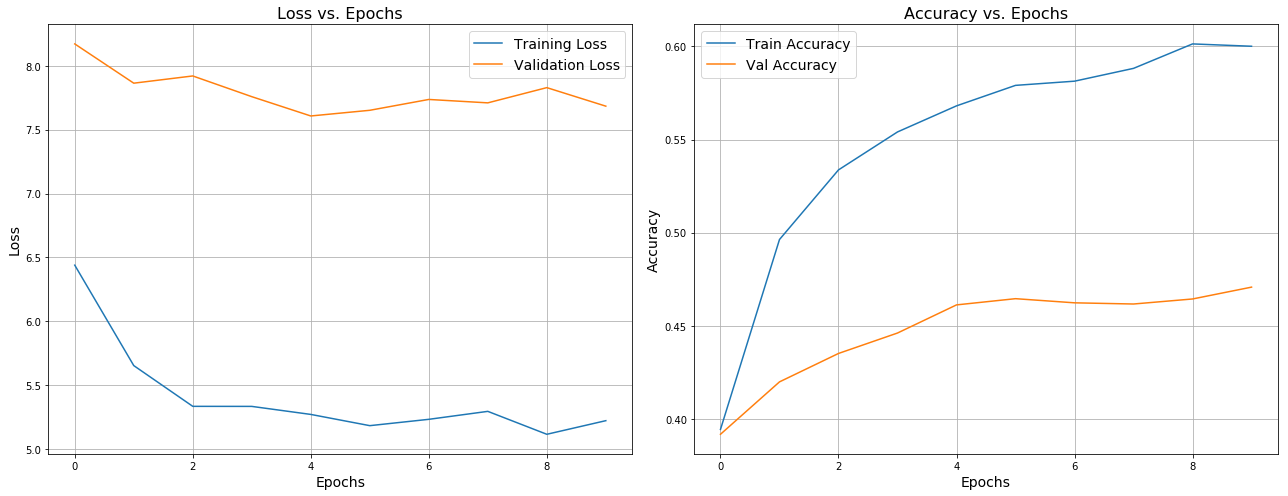

In [24]:
# Visualize the training process
train_loss = history.history['loss']
train_acc = history.history['acc']
val_loss = history.history['val_loss']
val_acc = history.history['val_acc']

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 7))
ax[0].plot(train_loss, label='Training Loss')
ax[0].plot(val_loss, label='Validation Loss')
ax[0].set_title('Loss vs. Epochs', fontsize=16)
ax[0].set_xlabel('Epochs', fontsize=14)
ax[0].set_ylabel('Loss', fontsize=14)
ax[0].legend(fontsize=14)
ax[0].grid(True)

ax[1].plot(train_acc, label='Train Accuracy')
ax[1].plot(val_acc, label='Val Accuracy')
ax[1].set_title('Accuracy vs. Epochs', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=14)
ax[1].set_ylabel('Accuracy', fontsize=14)
ax[1].legend(fontsize=14)
ax[1].grid(True)
plt.tight_layout()
plt.show()

# 6. DenseNet121

In [25]:
# For reproduciable purpose
seed = 42
K.clear_session()
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(seed)
random.seed(seed)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
tf.set_random_seed(seed)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

# Define parameters
classes = [str(i) for i in range(1, 129)]

# define image generator
train_gen = ImageDataGenerator(rescale=1.0/255)
train_generator = train_gen.flow_from_directory(train_dir, batch_size=160, classes=classes, 
                                                target_size=(224, 224))

val_gen = ImageDataGenerator(rescale=1.0/255)
val_generator = val_gen.flow_from_directory(val_dir, batch_size=286, classes=classes, 
                                            target_size=(224, 224))

Found 191680 images belonging to 128 classes.
Found 6292 images belonging to 128 classes.


### Initial training

In [26]:
# Load pre-trained DenseNet121
densenet_base = DenseNet121(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Define new CNN models
densenet = Sequential()
densenet.add(densenet_base)
densenet.add(Flatten(name='flatten'))
densenet.add(Dense(128, activation='softmax', name='prediction'))

# Make base model untrainable
densenet_base.trainable = False

# Model summary
densenet.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 7, 7, 1024)        7037504   
_________________________________________________________________
flatten (Flatten)            (None, 50176)             0         
_________________________________________________________________
prediction (Dense)           (None, 128)               6422656   
Total params: 13,460,160
Trainable params: 6,422,656
Non-trainable params: 7,037,504
_________________________________________________________________


In [27]:
# Compile the model
opt = keras.optimizers.Adam(lr=lr_schedule(0))
densenet.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Create call backs
checkpoint = ModelCheckpoint(filepath='./models/densenet_1_initial.h5', verbose=0, 
                             monitor='val_acc', save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=5, min_lr=0.5e-6)
callbacks = [checkpoint, lr_reducer, lr_scheduler]

# fit the mode
history = densenet.fit_generator(train_generator, steps_per_epoch=100, epochs=10, verbose=2, 
                                 callbacks=callbacks, validation_data=val_generator, validation_steps=22)
_ = gc.collect()

Learning rate:  0.001
Epoch 1/10
Learning rate:  0.001
 - 228s - loss: 6.9317 - acc: 0.4414 - val_loss: 8.3799 - val_acc: 0.3929
Epoch 2/10
Learning rate:  0.001
 - 196s - loss: 6.7696 - acc: 0.5099 - val_loss: 8.6091 - val_acc: 0.4007
Epoch 3/10
Learning rate:  0.001
 - 196s - loss: 6.6420 - acc: 0.5326 - val_loss: 8.0986 - val_acc: 0.4366
Epoch 4/10
Learning rate:  0.001
 - 199s - loss: 6.5993 - acc: 0.5434 - val_loss: 8.1081 - val_acc: 0.4463
Epoch 5/10
Learning rate:  0.001
 - 204s - loss: 6.7105 - acc: 0.5401 - val_loss: 8.4134 - val_acc: 0.4321
Epoch 6/10
Learning rate:  0.001
 - 196s - loss: 6.5974 - acc: 0.5504 - val_loss: 8.6077 - val_acc: 0.4267
Epoch 7/10
Learning rate:  0.001
 - 196s - loss: 6.4830 - acc: 0.5624 - val_loss: 8.3494 - val_acc: 0.4429
Epoch 8/10
Learning rate:  0.001
 - 198s - loss: 6.4777 - acc: 0.5636 - val_loss: 8.1630 - val_acc: 0.4569
Epoch 9/10
Learning rate:  0.001
 - 198s - loss: 6.5245 - acc: 0.5624 - val_loss: 8.1184 - val_acc: 0.4620
Epoch 10/10
Lea

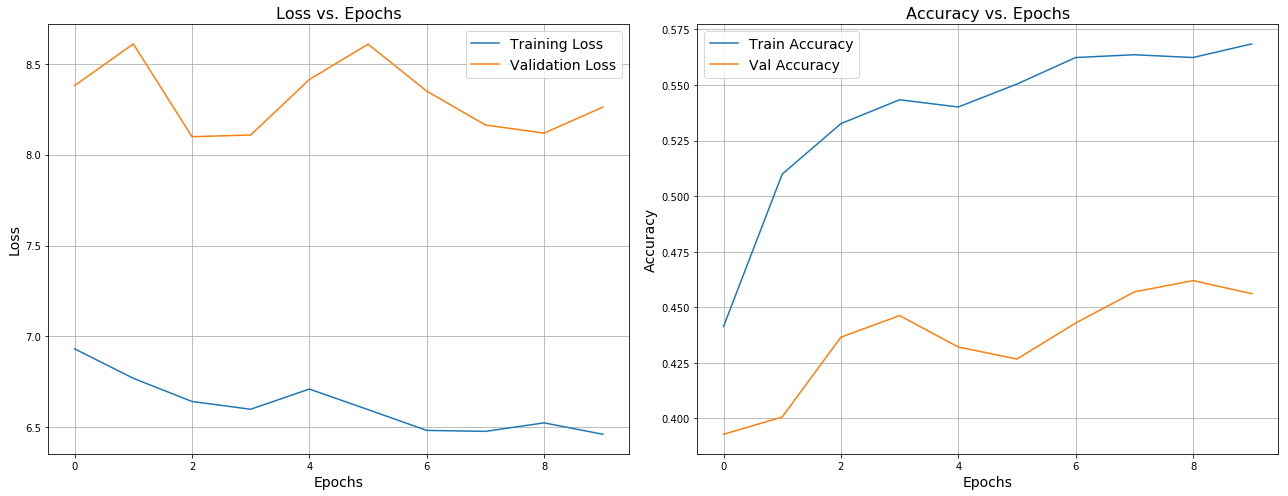

In [28]:
# Visualize the training process
train_loss = history.history['loss']
train_acc = history.history['acc']
val_loss = history.history['val_loss']
val_acc = history.history['val_acc']

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 7))
ax[0].plot(train_loss, label='Training Loss')
ax[0].plot(val_loss, label='Validation Loss')
ax[0].set_title('Loss vs. Epochs', fontsize=16)
ax[0].set_xlabel('Epochs', fontsize=14)
ax[0].set_ylabel('Loss', fontsize=14)
ax[0].legend(fontsize=14)
ax[0].grid(True)

ax[1].plot(train_acc, label='Train Accuracy')
ax[1].plot(val_acc, label='Val Accuracy')
ax[1].set_title('Accuracy vs. Epochs', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=14)
ax[1].set_ylabel('Accuracy', fontsize=14)
ax[1].legend(fontsize=14)
ax[1].grid(True)
plt.tight_layout()
plt.show()

# Make Predictions

### Load test images

In [29]:
# # Load test images
# test_ids = []
# test_images = []
# for idx in test_df['id'].values:
#     if os.path.exists('./data/test/' + str(idx) + '.jpg'):
#         img = Image.open('./data/test/' + str(idx) + '.jpg')
#         if img.mode != 'RGB':
#             img = img.convert('RGB')
#         img = img.resize((224, 224))
#         img = np.asarray(img, dtype=K.floatx())
#         test_images.append(img)
#         test_ids.append(idx)

# # Re-scale the images
# test_images = np.array(test_images, dtype=K.floatx())
# test_images = test_images / 255.0

### 1. VGG16

In [30]:
# # Load the saved model
# vgg16 = load_model('./models/vgg16_1_initial.h5')

# # Make predictions
# test_pred = vgg16.predict(test_images)
# test_label = np.argmax(test_pred, axis=1) + 1

# # Sample submission
# sample_submission = pd.read_csv('./data/sample_submission.csv', usecols=['id'])
# df_submission = pd.DataFrame({'id': test_ids, 'predicted': test_label})

# # Merge together
# df_submission = pd.merge(sample_submission, df_submission, how='left', on='id')

# # Fill missing values
# n = df_submission['predicted'].isnull().sum()
# guess = np.random.choice(range(1, 129), n, replace=True)
# df_submission[df_submission['predicted'].isnull()]['predicted'] = guess

# # Save to disk
# df_submission.to_csv('./result/vgg16_1_initial.csv', columns=['id', 'predicted'], index=False)

### 2. VGG19

In [31]:
# # Load the saved model
# vgg19 = load_model('./models/vgg19_1_initial.h5')

# # Make predictions
# test_pred = vgg19.predict(test_images)
# test_label = np.argmax(test_pred, axis=1) + 1

# # Sample submission
# sample_submission = pd.read_csv('./data/sample_submission.csv', usecols=['id'])
# df_submission = pd.DataFrame({'id': test_ids, 'predicted': test_label})

# # Merge together
# df_submission = pd.merge(sample_submission, df_submission, how='left', on='id')

# # Fill missing values
# n = df_submission['predicted'].isnull().sum()
# guess = np.random.choice(range(1, 129), n, replace=True)
# df_submission[df_submission['predicted'].isnull()]['predicted'] = guess

# # Save to disk
# df_submission.to_csv('./result/vgg19_1_initial.csv', columns=['id', 'predicted'], index=False)

### 3. ResNet50

In [32]:
# # Load the saved model
# resnet = load_model('./models/resnet_1_initial.h5')

# # Make predictions
# test_pred = resnet.predict(test_images)
# test_label = np.argmax(test_pred, axis=1) + 1

# # Sample submission
# sample_submission = pd.read_csv('./data/sample_submission.csv', usecols=['id'])
# df_submission = pd.DataFrame({'id': test_ids, 'predicted': test_label})

# # Merge together
# df_submission = pd.merge(sample_submission, df_submission, how='left', on='id')

# # Fill missing values
# n = df_submission['predicted'].isnull().sum()
# guess = np.random.choice(range(1, 129), n, replace=True)
# df_submission[df_submission['predicted'].isnull()]['predicted'] = guess

# # Save to disk
# df_submission.to_csv('./result/resnet_1_initial.csv', columns=['id', 'predicted'], index=False)

### 4. InceptionV3

In [33]:
# # Load the saved model
# inception = load_model('./models/inception_1_initial.h5')

# # Make predictions
# test_pred = inception.predict(test_images)
# test_label = np.argmax(test_pred, axis=1) + 1

# # Sample submission
# sample_submission = pd.read_csv('./data/sample_submission.csv', usecols=['id'])
# df_submission = pd.DataFrame({'id': test_ids, 'predicted': test_label})

# # Merge together
# df_submission = pd.merge(sample_submission, df_submission, how='left', on='id')

# # Fill missing values
# n = df_submission['predicted'].isnull().sum()
# guess = np.random.choice(range(1, 129), n, replace=True)
# df_submission[df_submission['predicted'].isnull()]['predicted'] = guess

# # Save to disk
# df_submission.to_csv('./result/inception_1_initial.csv', columns=['id', 'predicted'], index=False)

### 5. Xception

In [34]:
# # Load the saved model
# xception = load_model('./models/xception_1_initial.h5')

# # Make predictions
# test_pred = xception.predict(test_images)
# test_label = np.argmax(test_pred, axis=1) + 1

# # Sample submission
# sample_submission = pd.read_csv('./data/sample_submission.csv', usecols=['id'])
# df_submission = pd.DataFrame({'id': test_ids, 'predicted': test_label})

# # Merge together
# df_submission = pd.merge(sample_submission, df_submission, how='left', on='id')

# # Fill missing values
# n = df_submission['predicted'].isnull().sum()
# guess = np.random.choice(range(1, 129), n, replace=True)
# df_submission[df_submission['predicted'].isnull()]['predicted'] = guess

# # Save to disk
# df_submission.to_csv('./result/xception_1_initial.csv', columns=['id', 'predicted'], index=False)

### 6. DenseNet121

In [35]:
# # Load the saved model
# densenet = load_model('./models/densenet_1_initial.h5')

# # Make predictions
# test_pred = densenet.predict(test_images)
# test_label = np.argmax(test_pred, axis=1) + 1

# # Sample submission
# sample_submission = pd.read_csv('./data/sample_submission.csv', usecols=['id'])
# df_submission = pd.DataFrame({'id': test_ids, 'predicted': test_label})

# # Merge together
# df_submission = pd.merge(sample_submission, df_submission, how='left', on='id')

# # Fill missing values
# n = df_submission['predicted'].isnull().sum()
# guess = np.random.choice(range(1, 129), n, replace=True)
# df_submission[df_submission['predicted'].isnull()]['predicted'] = guess

# # Save to disk
# df_submission.to_csv('./result/densenet_1_initial.csv', columns=['id', 'predicted'], index=False)